In [1]:
from typing import List, Dict, Iterable, Tuple, Callable
from matplotlib import pyplot as plt
from collections import Counter
# import pygal
import sys
import os
import string
import urllib.request
import requests
import curl
import pycurl
import webbrowser
import numpy as np
import math
import pandas as pd
# from IPython import qt
from matplotlib.pyplot import figure
from py.xml import raw
from requests.api import get
from matplotlib import pyplot as plt
# from scratch.working_with_data import rescale
# from scratch.multiple_regression import least_squares_fit, predict
# from scratch.gradient_descent import gradient_step

# from stats import mean, median, de_mean, standard_deviation, correlation
# from gradient_descent import minimize_stochastic, maximize_stochastic, maximize_batch
# from vector import dot, vector_add
# from normal import normal_cdf
# from matrix import make_matrix, get_column, shape, matrix_multiply
# from logistic_regression import *

import math
import os
import random
import sys
from functools import partial, reduce

from scipy.optimize import fmin_tnc

import tqdm

from typing import*

from collections import*
# from scipy import*
from sklearn.metrics import*

from numpy import *

# import mlxtend

# bltin_sum = np.sum

In [2]:
# Functions

# def add(a, b): return a + b

def vector_sum(vectors):
    """Sums all corresponding elements"""
    # Check that vectors is not empty
    assert vectors, "no vectors provided!"

    # Check the vectors are all the same size
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"

    # the i-th element of the result is the sum of every vector[i]
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

def scalar_multiply(c , v):
    """Multiplies every element by c"""
    return [c * v_i for v_i in v]

def vector_mean(vectors):
    """Computes the element-wise average"""
    n = len(vectors)
    m = np.sum(vectors,axis=0)
    vec_mean = np.multiply(1/n,m)
    return vec_mean

def de_mean(xs):
    """Translate xs by subtracting its mean (so the result has mean 0)"""
    x_bar = np.mean(xs)
    d_mean = [x - x_bar for x in xs]
    return d_mean

def dot(v, w):
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def variance(xs):
    """Almost the average squared deviation from the mean"""
    assert len(xs) >= 2, "variance requires at least two elements"

    n = len(xs)
    deviations = de_mean(xs)
    vari = sum_of_squares(deviations)/(n-1)
    return vari

# Standard deviation                        
def standard_deviation(xs):
    """The standard deviation is the square root of the variance"""
    std_dev = np.sqrt(variance(xs)) 
    return std_dev

def scale(data):
    """returns the mean and standard deviation for each position"""
    dim = len(data[0])
    
    # Vector Mean
#     n = len(data)
#     m = np.sum(data,axis=0)
#     means = np.multiply(1/n,m)
    means = vector_mean(data)
    
    # Standard Deviaiton
    stdevs = [standard_deviation([vector[i] for vector in data])
              for i in range(dim)]
    return means,stdevs

def rescale(data):
    """
    Rescales the input data so that each position has
    mean 0 and standard deviation 1. (Leaves a position
    as is if its standard deviation is 0.)
    """
    dim = len(data[0])
    means, stdevs = scale(data)
    
    means = list(means)
    stdevs = list(stdevs)

    # Make a copy of each vector
    rescaled = [v[:] for v in data]
    v0 = []
    for v in rescaled:
        v = list(v)
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]
        v0.append(v)

    return v0

def gradient_step(v, gradient, step_size):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    grad_step = np.add(v,step)
    return grad_step

# def predict(alpha, beta, x_i):
#     pred = beta * x_i + alpha
#     return pred

# def error(x, y, beta):
#     """
#     The error from predicting beta * x_i + alpha
#     when the actual value is y_i
#     """
#     err_fin = predict(alpha, beta, x_i) - y_i
#     return err_fin

def predict(x, beta):
    """assumes that the first element of x is 1"""
    return dot(x, beta)

def error(x, y, beta):
    return predict(x, beta) - y 

def sqerror_gradient(x, y, beta):
    err = error(x, y, beta)
    err_fin = [2 * err * x_i for x_i in x]
    return err_fin

def least_squares_fit(xs, ys, learning_rate = 0.001, num_steps = 1000, batch_size = 1):
    """
    Find the beta that minimizes the sum of squared errors
    assuming the model y = dot(x, beta).
    """
    # Start with a random guess
    guess = [np.random.random() for _ in xs[0]]

    for _ in tqdm.trange(num_steps, desc="least squares fit"):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_gradient(x, y, guess)
                                    for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)

    return guess

def logistic(x):
    return 1.0 / (1 + math.exp(-x))

def logistic_prime(x):
    y = logistic(x)
    return y * (1 - y)

def _negative_log_likelihood(x, y, beta):
    """The negative log likelihood for one data point""" 
    if y == 1:
        return -math.log(logistic(dot(x, beta)))
    else:
        return -math.log(1 - logistic(dot(x, beta)))
    
def negative_log_likelihood(xs, ys, beta):
    return sum(_negative_log_likelihood(x, y, beta)
               for x, y in zip(xs, ys))

def _negative_log_partial_j(x, y, beta, j):
    """
    The jth partial derivative for one data point.
    Here i is the index of the data point.
    """
    return -(y - logistic(dot(x, beta))) * x[j]

def _negative_log_gradient(x, y, beta):
    """
    The gradient for one data point.
    """
    return [_negative_log_partial_j(x, y, beta, j)
            for j in range(len(beta))]

def negative_log_gradient(xs, ys,beta):
    return vector_sum([_negative_log_gradient(x, y, beta)
                       for x, y in zip(xs, ys)])

def split_data(data, prob):
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.

def train_test_split(xs, ys, test_pct):
     # Generate the indices and split them
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

    return ([xs[i] for i in train_idxs],  # x_train 
            [xs[i] for i in test_idxs],   # x_test
            [ys[i] for i in train_idxs],  # y_train
            [ys[i] for i in test_idxs])   # y_test
                                                                



In [3]:
y = np.array([0, 1, 2, 2])

In [4]:
y_enc = (np.arange(np.max(y) + 1) == y[:, None]).astype(float)

print('one-hot encoding:\n', y_enc)

one-hot encoding:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [5]:
X = np.array([[0.1, 0.5],
              [1.1, 2.3],
              [-1.1, -2.3],
              [-1.5, -2.5]])

W = np.array([[0.1, 0.2, 0.3],
              [0.1, 0.2, 0.3]])

bias = np.array([0.01, 0.1, 0.1])

print('Inputs X:\n', X)
print('\nWeights W:\n', W)
print('\nbias:\n', bias)

Inputs X:
 [[ 0.1  0.5]
 [ 1.1  2.3]
 [-1.1 -2.3]
 [-1.5 -2.5]]

Weights W:
 [[0.1 0.2 0.3]
 [0.1 0.2 0.3]]

bias:
 [0.01 0.1  0.1 ]


In [6]:
X = np.array([[0.1, 0.5],
              [1.1, 2.3],
              [-1.1, -2.3],
              [-1.5, -2.5]])

W = np.array([[0.1, 0.2, 0.3],
              [0.1, 0.2, 0.3]])

bias = np.array([0.01, 0.1, 0.1])

print('Inputs X:\n', X)
print('\nWeights W:\n', W)
print('\nbias:\n', bias)

Inputs X:
 [[ 0.1  0.5]
 [ 1.1  2.3]
 [-1.1 -2.3]
 [-1.5 -2.5]]

Weights W:
 [[0.1 0.2 0.3]
 [0.1 0.2 0.3]]

bias:
 [0.01 0.1  0.1 ]


In [7]:
def net_input(X, W, b):
    return (X.dot(W) + b)

net_in = net_input(X, W, bias)
print('net input:\n', net_in)

net input:
 [[ 0.07  0.22  0.28]
 [ 0.35  0.78  1.12]
 [-0.33 -0.58 -0.92]
 [-0.39 -0.7  -1.1 ]]


In [8]:
def softmax(z):
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

smax = softmax(net_in)
print('softmax:\n', smax)

softmax:
 [[0.29450637 0.34216758 0.36332605]
 [0.21290077 0.32728332 0.45981591]
 [0.42860913 0.33380113 0.23758974]
 [0.44941979 0.32962558 0.22095463]]


In [9]:
def to_classlabel(z):
    return z.argmax(axis=1)

print('predicted class labels: ', to_classlabel(smax))

predicted class labels:  [2 2 0 0]


In [10]:
def cross_entropy(output, y_target):
    return - np.sum(np.log(output) * (y_target), axis=1)

xent = cross_entropy(smax, y_enc)
print('Cross Entropy:', xent)

Cross Entropy: [1.22245465 1.11692907 1.43720989 1.50979788]


In [11]:
def cost(output, y_target):
    return np.mean(cross_entropy(output, y_target))

J_cost = cost(smax, y_enc)
print('Cost: ', J_cost)

Cost:  1.3215978715930938


In [12]:
# Sebastian Raschka 2014-2020
# mlxtend Machine Learning Library Extensions
#
# Base Clusteer (Clutering Parent Class)
# Author: Sebastian Raschka <sebastianraschka.com>
#
# License: BSD 3 clause

from time import time
from collections import defaultdict

try:
    from inspect import signature
except ImportError:
    from ..externals.signature_py27 import signature


class _BaseModel(object):

    def __init__(self):
        self._init_time = time()

    def _check_arrays(self, X, y=None):
        if isinstance(X, list):
            raise ValueError('X must be a numpy array')
        if not len(X.shape) == 2:
            raise ValueError('X must be a 2D array. Try X[:, numpy.newaxis]')
        try:
            if y is None:
                return
        except(AttributeError):
            if not len(y.shape) == 1:
                raise ValueError('y must be a 1D array.')

        if not len(y) == X.shape[0]:
            raise ValueError('X and y must contain the same number of samples')

    @classmethod
    def _get_param_names(cls):
        """Get parameter names for the estimator
        adapted from
        https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/base.py
        Author: Gael Varoquaux <gael.varoquaux@normalesup.org>
        License: BSD 4 clause
        """
        # fetch the constructor or the original constructor before
        # deprecation wrapping if any
        init = getattr(cls.__init__, 'deprecated_original', cls.__init__)
        if init is object.__init__:
            # No explicit constructor to introspect
            return []

        # introspect the constructor arguments to find the model parameters
        # to represent
        init_signature = signature(init)
        # Consider the constructor parameters excluding 'self'
        parameters = [p for p in init_signature.parameters.values()
                      if p.name != 'self' and p.kind != p.VAR_KEYWORD]
        for p in parameters:
            if p.kind == p.VAR_POSITIONAL:
                raise RuntimeError("scikit-learn estimators should always "
                                   "specify their parameters in the signature"
                                   " of their __init__ (no varargs)."
                                   " %s with constructor %s doesn't "
                                   " follow this convention."
                                   % (cls, init_signature))
        # Extract and sort argument names excluding 'self'
        return sorted([p.name for p in parameters])

    def get_params(self, deep=True):
        """Get parameters for this estimator.
        Parameters
        ----------
        deep : boolean, optional
            If True, will return the parameters for this estimator and
            contained subobjects that are estimators.
        Returns
        -------
        params : mapping of string to any
            Parameter names mapped to their values.'
        adapted from
        https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/base.py
        Author: Gael Varoquaux <gael.varoquaux@normalesup.org>
        License: BSD 3 clause
        """
        out = dict()
        for key in self._get_param_names():
            value = getattr(self, key, None)
            if deep and hasattr(value, 'get_params'):
                deep_items = value.get_params().items()
                out.update((key + '__' + k, val) for k, val in deep_items)
            out[key] = value
        return out

    def set_params(self, **params):
        """Set the parameters of this estimator.
        The method works on simple estimators as well as on nested objects
        (such as pipelines). The latter have parameters of the form
        ``<component>__<parameter>`` so that it's possible to update each
        component of a nested object.
        Returns
        -------
        self
        adapted from
        https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/base.py
        Author: Gael Varoquaux <gael.varoquaux@normalesup.org>
        License: BSD 3 clause
        """
        if not params:
            # Simple optimization to gain speed (inspect is slow)
            return self
        valid_params = self.get_params(deep=True)

        nested_params = defaultdict(dict)  # grouped by prefix
        for key, value in params.items():
            key, delim, sub_key = key.partition('__')
            if key not in valid_params:
                raise ValueError('Invalid parameter %s for estimator %s. '
                                 'Check the list of available parameters '
                                 'with `estimator.get_params().keys()`.' %
                                 (key, self))

            if delim:
                nested_params[key][sub_key] = value
            else:
                setattr(self, key, value)
                valid_params[key] = value

        for key, sub_params in nested_params.items():
            valid_params[key].set_params(**sub_params)

        return self

In [13]:
# Sebastian Raschka 2014-2020
# mlxtend Machine Learning Library Extensions
#
# Base Clusteer (Clutering Parent Class)
# Author: Sebastian Raschka <sebastianraschka.com>
#
# License: BSD 3 clause

import numpy as np
from sys import stderr
from time import time


class _IterativeModel(object):

    def __init__(self):
        pass

    def _shuffle_arrays(self, arrays):
        """Shuffle arrays in unison."""
        r = np.random.permutation(len(arrays[0]))
        return [ary[r] for ary in arrays]

    def _print_progress(self, iteration, n_iter,
                        cost=None, time_interval=10):
        if self.print_progress > 0:
            s = '\rIteration: %d/%d' % (iteration, n_iter)
            if cost:
                s += ' | Cost %.2f' % cost
            if self.print_progress > 1:
                if not hasattr(self, 'ela_str_'):
                    self.ela_str_ = '00:00:00'
                if not iteration % time_interval:
                    ela_sec = time() - self._init_time
                    self.ela_str_ = self._to_hhmmss(ela_sec)
                s += ' | Elapsed: %s' % self.ela_str_
                if self.print_progress > 2:
                    if not hasattr(self, 'eta_str_'):
                        self.eta_str_ = '00:00:00'
                    if not iteration % time_interval:
                        eta_sec = ((ela_sec / float(iteration)) *
                                   n_iter - ela_sec)
                        if eta_sec < 0.0:
                            eta_sec = 0.0
                        self.eta_str_ = self._to_hhmmss(eta_sec)
                    s += ' | ETA: %s' % self.eta_str_
            stderr.write(s)
            stderr.flush()

    def _to_hhmmss(self, sec):
        m, s = divmod(sec, 60)
        h, m = divmod(m, 60)
        return "%d:%02d:%02d" % (h, m, s)

    def _yield_minibatches_idx(self, rgen, n_batches, data_ary, shuffle=True):
            indices = np.arange(data_ary.shape[0])

            if shuffle:
                indices = rgen.permutation(indices)
            if n_batches > 1:
                remainder = data_ary.shape[0] % n_batches

                if remainder:
                    minis = np.array_split(indices[:-remainder], n_batches)
                    minis[-1] = np.concatenate((minis[-1],
                                                indices[-remainder:]),
                                               axis=0)
                else:
                    minis = np.array_split(indices, n_batches)

            else:
                minis = (indices,)

            for idx_batch in minis:
                yield idx_batch

    def _init_params(self, weights_shape, bias_shape=(1,),
                     random_seed=None, dtype='float64', scale=0.01,
                     bias_const=0.0):
        """Initialize weight coefficients."""
        rgen = np.random.RandomState(random_seed)
        w = rgen.normal(loc=0.0, scale=scale, size=weights_shape)
        b = np.zeros(shape=bias_shape)
        if bias_const != 0.0:
            b += bias_const
        return b.astype(dtype), w.astype(dtype)

In [14]:
# Sebastian Raschka 2014-2020
# mlxtend Machine Learning Library Extensions
#
# Base Clusteer (Clutering Parent Class)
# Author: Sebastian Raschka <sebastianraschka.com>
#
# License: BSD 3 clause

import numpy as np


class _MultiClass(object):

    def __init__(self):
        pass

    def _one_hot(self, y, n_labels, dtype):
        """Returns a matrix where each sample in y is represented
           as a row, and each column represents the class label in
           the one-hot encoding scheme.
        Example:
            y = np.array([0, 1, 2, 3, 4, 2])
            mc = _BaseMultiClass()
            mc._one_hot(y=y, n_labels=5, dtype='float')
            np.array([[1., 0., 0., 0., 0.],
                      [0., 1., 0., 0., 0.],
                      [0., 0., 1., 0., 0.],
                      [0., 0., 0., 1., 0.],
                      [0., 0., 0., 0., 1.],
                      [0., 0., 1., 0., 0.]])
        """
        mat = np.zeros((len(y), n_labels))
        for i, val in enumerate(y):
            mat[i, val] = 1
        return mat.astype(dtype)

In [15]:

import numpy as np
from time import time


class _Classifier(object):

    def __init__(self):
        pass

    def _check_target_array(self, y, allowed=None):
        if not isinstance(y[0], (int, np.integer)):
            raise AttributeError('y must be an integer array.\nFound %s'
                                 % y.dtype)
        found_labels = np.unique(y)
        if (found_labels < 0).any():
            raise AttributeError('y array must not contain negative labels.'
                                 '\nFound %s' % found_labels)
        if allowed is not None:
            found_labels = tuple(found_labels)
            if found_labels not in allowed:
                raise AttributeError('Labels not in %s.\nFound %s'
                                     % (allowed, found_labels))

    def score(self, X, y):
        """ Compute the prediction accuracy
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values (true class labels).
        Returns
        ---------
        acc : float
            The prediction accuracy as a float
            between 0.0 and 1.0 (perfect score).
        """
        y_pred = self.predict(X)
        acc = np.sum(y == y_pred, axis=0) / float(X.shape[0])
        return acc

    def fit(self, X, y, init_params=True):
        """Learn model from training data.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.
        init_params : bool (default: True)
            Re-initializes model parameters prior to fitting.
            Set False to continue training with weights from
            a previous model fitting.
        Returns
        -------
        self : object
        """
        self._is_fitted = False
        self._check_arrays(X=X, y=y)
        self._check_target_array(y)
        if hasattr(self, 'self.random_seed') and self.random_seed:
            self._rgen = np.random.RandomState(self.random_seed)
        self._init_time = time()
        self._fit(X=X, y=y, init_params=init_params)
        self._is_fitted = True
        return self

    def predict(self, X):
        """Predict targets from X.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        Returns
        ----------
        target_values : array-like, shape = [n_samples]
          Predicted target values.
        """
        self._check_arrays(X=X)
        if not self._is_fitted:
            raise AttributeError('Model is not fitted, yet.')
        return self._predict(X)

In [16]:
  
# Sebastian Raschka 2014-2020
# mlxtend Machine Learning Library Extensions
#
# Implementation of the mulitnomial logistic regression algorithm for
# classification.

# Author: Sebastian Raschka <sebastianraschka.com>
#
# License: BSD 3 clause

import numpy as np
from time import time
# from .._base import _BaseModel
# from .._base import _IterativeModel
# from .._base import _MultiClass
# from .._base import _Classifier


class SoftmaxRegression(_BaseModel, _IterativeModel,
                        _Classifier,  _MultiClass):

    """Softmax regression classifier.
    Parameters
    ------------
    eta : float (default: 0.01)
        Learning rate (between 0.0 and 1.0)
    epochs : int (default: 50)
        Passes over the training dataset.
        Prior to each epoch, the dataset is shuffled
        if `minibatches > 1` to prevent cycles in stochastic gradient descent.
    l2 : float
        Regularization parameter for L2 regularization.
        No regularization if l2=0.0.
    minibatches : int (default: 1)
        The number of minibatches for gradient-based optimization.
        If 1: Gradient Descent learning
        If len(y): Stochastic Gradient Descent (SGD) online learning
        If 1 < minibatches < len(y): SGD Minibatch learning
    n_classes : int (default: None)
        A positive integer to declare the number of class labels
        if not all class labels are present in a partial training set.
        Gets the number of class labels automatically if None.
    random_seed : int (default: None)
        Set random state for shuffling and initializing the weights.
    print_progress : int (default: 0)
        Prints progress in fitting to stderr.
        0: No output
        1: Epochs elapsed and cost
        2: 1 plus time elapsed
        3: 2 plus estimated time until completion
    Attributes
    -----------
    w_ : 2d-array, shape={n_features, 1}
      Model weights after fitting.
    b_ : 1d-array, shape={1,}
      Bias unit after fitting.
    cost_ : list
        List of floats, the average cross_entropy for each epoch.
    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/classifier/SoftmaxRegression/
    """
    def __init__(self, eta=0.01, epochs=50,
                 l2=0.0,
                 minibatches=1,
                 n_classes=None,
                 random_seed=None,
                 print_progress=0):

        _BaseModel.__init__(self)
        _IterativeModel.__init__(self)
        _Classifier.__init__(self)
        _MultiClass.__init__(self)

        self.eta = eta
        self.epochs = epochs
        self.l2 = l2
        self.minibatches = minibatches
        self.n_classes = n_classes
        self.random_seed = random_seed
        self.print_progress = print_progress
        self._is_fitted = False

    def _net_input(self, X, W, b):
        return (X.dot(W) + b)

    def _softmax(self, z):
        e_x = np.exp(z - z.max(axis=1, keepdims=True))
        out = e_x / e_x.sum(axis=1, keepdims=True)
        return out
        # return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

    def _cross_entropy(self, output, y_target):
        return - np.sum(np.log(output) * (y_target), axis=1)

    def _cost(self, cross_entropy):
        L2_term = self.l2 * np.sum(self.w_ ** 2)
        cross_entropy = cross_entropy + L2_term
        return 0.5 * np.mean(cross_entropy)

    def _to_classlabels(self, z):
        return z.argmax(axis=1)

    def _fit(self, X, y, init_params=True):
        self._check_target_array(y)
        if init_params:
            if self.n_classes is None:
                self.n_classes = np.max(y) + 1
            self._n_features = X.shape[1]

            self.b_, self.w_ = self._init_params(
                weights_shape=(self._n_features, self.n_classes),
                bias_shape=(self.n_classes,),
                random_seed=self.random_seed)
            self.cost_ = []

        y_enc = self._one_hot(y=y, n_labels=self.n_classes, dtype=np.float)

        self.init_time_ = time()
        rgen = np.random.RandomState(self.random_seed)
        for i in range(self.epochs):
            for idx in self._yield_minibatches_idx(
                    rgen=rgen,
                    n_batches=self.minibatches,
                    data_ary=y,
                    shuffle=True):

                # givens:
                # w_ -> n_feat x n_classes
                # b_  -> n_classes

                # net_input, softmax and diff -> n_samples x n_classes:
                net = self._net_input(X[idx], self.w_, self.b_)
                softm = self._softmax(net)
                diff = softm - y_enc[idx]

                # gradient -> n_features x n_classes
                grad = np.dot(X[idx].T, diff)

                # update in opp. direction of the cost gradient
                self.w_ -= (self.eta * grad +
                            self.eta * self.l2 * self.w_)
                self.b_ -= (self.eta * np.sum(diff, axis=0))

            # compute cost of the whole epoch
            net = self._net_input(X, self.w_, self.b_)
            softm = self._softmax(net)
            cross_ent = self._cross_entropy(output=softm, y_target=y_enc)
            cost = self._cost(cross_ent)
            self.cost_.append(cost)

            if self.print_progress:
                self._print_progress(iteration=i + 1,
                                     n_iter=self.epochs,
                                     cost=cost)

        return self

    def predict_proba(self, X):
        """Predict class probabilities of X from the net input.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        Returns
        ----------
        Class probabilties : array-like, shape= [n_samples, n_classes]
        """
        net = self._net_input(X, self.w_, self.b_)
        softm = self._softmax(net)
        return softm

    def _predict(self, X):
        probas = self.predict_proba(X)
        return self._to_classlabels(probas)

In [17]:

df = pd.read_csv('iris.dat', names=[ "sepal length in cm",  "sepal width in cm", "petal length in cm", "petal width in cm",
  "class"])
df.head()

clr = []
for i in range(len(df['class'])):
    if df['class'][i] not in clr:
        clr.append(df['class'][i])
clr

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

In [18]:
X = df.iloc[:, [0, 3]] # sepal length and petal width
X = (X - X.mean())/X.std()
X.head()

y0 = df['class']
y = y0
for i in range(len(y0)):
#     print(i)
    if y0[i] == 'Iris-setosa':
        y[i] = 0
    elif y0[i] == 'Iris-versicolor':
        y[i] = 1
    elif y0[i] == 'Iris-virginica':
        y[i] = 2
y.to_numpy()
X.to_numpy()

C:\Users\USER\AppData\Local\Temp/ipykernel_37972/1538601023.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[i] = 0
C:\Users\USER\AppData\Local\Temp/ipykernel_37972/1538601023.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[i] = 1
C:\Users\USER\AppData\Local\Temp/ipykernel_37972/1538601023.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[i] = 2


array([[-8.97673879e-01, -1.30859282e+00],
       [-1.13920048e+00, -1.30859282e+00],
       [-1.38072709e+00, -1.30859282e+00],
       [-1.50149039e+00, -1.30859282e+00],
       [-1.01843718e+00, -1.30859282e+00],
       [-5.35383973e-01, -1.04652483e+00],
       [-1.50149039e+00, -1.17755883e+00],
       [-1.01843718e+00, -1.30859282e+00],
       [-1.74301699e+00, -1.30859282e+00],
       [-1.13920048e+00, -1.43962681e+00],
       [-5.35383973e-01, -1.30859282e+00],
       [-1.25996379e+00, -1.30859282e+00],
       [-1.25996379e+00, -1.43962681e+00],
       [-1.86378030e+00, -1.43962681e+00],
       [-5.23307643e-02, -1.30859282e+00],
       [-1.73094066e-01, -1.04652483e+00],
       [-5.35383973e-01, -1.04652483e+00],
       [-8.97673879e-01, -1.17755883e+00],
       [-1.73094066e-01, -1.17755883e+00],
       [-8.97673879e-01, -1.17755883e+00],
       [-5.35383973e-01, -1.30859282e+00],
       [-8.97673879e-01, -1.04652483e+00],
       [-1.50149039e+00, -1.30859282e+00],
       [-8.

In [19]:
# import numpy as np
# import os

# this_dir, this_filename = os.path.split("I:\Back Up\Deep\Principles of Machine Learning\Code\iris.csv.gz")

# # this_dir, this_filename = os.path.split("http://localhost:8888/edit/Deep/Principles%20of%20Machine%20Learning/Deep%20Learning/iris.csv.gz")
# DATA_PATH = os.path.join(this_dir, "iris.csv.gz")
# # DATA_PATH = df = pd.read_csv('iris.dat', names=[ "sepal length in cm",  "sepal width in cm", "petal length in cm", "petal width in cm",
# #   "class"])
# # DATA_PATH = DATA_PATH.to_numpy()
# # DATA_PATH = "I:\Back Up\Deep\Principles of Machine Learning\Code\iris.csv.gz"


# def iris_data(version='uci'):
#     """Iris flower dataset.
#     Source : https://archive.ics.uci.edu/ml/datasets/Iris
#     Number of samples : 150
#     Class labels : {0, 1, 2}, distribution: [50, 50, 50]
#         0 = setosa, 1 = versicolor, 2 = virginica.
#     Dataset Attributes:
#         - 1) sepal length [cm]
#         - 2) sepal width [cm]
#         - 3) petal length [cm]
#         - 4) petal width [cm]
#     Parameters
#     --------
#     version : string, optional (default: 'uci').
#       Version to use {'uci', 'corrected'}. 'uci' loads the dataset
#       as deposited on the UCI machine learning repository, and 
#       'corrected' provides the version that is consistent with
#       Fisher's original paper. See Note for details.
#     Returns
#     --------
#     X, y : [n_samples, n_features], [n_class_labels]
#         X is the feature matrix with 150 flower samples as rows,
#         and 4 feature columns sepal length, sepal width,
#         petal length, and petal width.
#         y is a 1-dimensional array of the class labels {0, 1, 2}
#     Note
#     --------
#     The Iris dataset (originally collected by Edgar Anderson) and
#     available in UCI's machine learning repository is different from
#     the Iris dataset described in the original paper by  R.A. Fisher [1]). 
#     Precisely, there are two data points (row number
#     34 and 37) in UCI's Machine Learning repository are different from the
#     origianlly published Iris dataset. Also, the original version of the Iris
#     Dataset, which can be loaded via `version='corrected'` is the same
#     as the one in R.
#     [1] . A. Fisher (1936). "The use of multiple measurements in taxonomic
#     problems". Annals of Eugenics. 7 (2): 179–188
#     Examples
#     -----------
#     For usage examples, please see
#     http://rasbt.github.io/mlxtend/user_guide/data/iris_data/
#     """
#     if version == "uci":
#         tmp = np.genfromtxt(fname=DATA_PATH, delimiter=',')
#         X, y = tmp[:, :-1], tmp[:, -1]
#         y = y.astype(int)
#     elif version == "corrected":
#         tmp = np.genfromtxt(fname=DATA_PATH, delimiter=',')
#         X, y = tmp[:, :-1], tmp[:, -1]
#         X[34] = [4.9, 3.1, 1.5, 0.2]
#         X[37] = [4.9, 3.6, 1.4, 0.1]
#         y = y.astype(int)
#     else:
#         raise ValueError("version must be 'uci' or 'corrected'.")
#     return X, y


In [20]:
lr = SoftmaxRegression(eta=0.01, 
                       epochs=500, 
                       minibatches=1, 
                       random_seed=1,
                       print_progress=3)
lr.fit(X.to_numpy(),y.to_numpy())

C:\Users\USER\AppData\Local\Temp/ipykernel_37972/1270259641.py:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_enc = self._one_hot(y=y, n_labels=self.n_classes, dtype=np.float)
Iteration: 500/500 | Cost 0.06 | Elapsed: 0:00:00 | ETA: 0:00:00

In [21]:
# Sebastian Raschka 2014-2020
# mlxtend Machine Learning Library Extensions
#
# A counter class for printing the progress of an iterator.
# Author: Sebastian Raschka <sebastianraschka.com>
#
# License: BSD 3 clause

import numpy as np


def check_Xy(X, y, y_int=True):

    # check types
    if not isinstance(X, np.ndarray):
        raise ValueError('X must be a NumPy array. Found %s' % type(X))
    if not isinstance(y, np.ndarray):
        raise ValueError('y must be a NumPy array. Found %s' % type(y))

    if 'int' not in str(y.dtype):
        raise ValueError('y must be an integer array. Found %s. '
                         'Try passing the array as y.astype(np.integer)'
                         % y.dtype)

    if not ('float' in str(X.dtype) or 'int' in str(X.dtype)):
        raise ValueError('X must be an integer or float array. Found %s.'
                         % X.dtype)

    # check dim
    if len(X.shape) != 2:
        raise ValueError('X must be a 2D array. Found %s' % str(X.shape))
    if len(y.shape) > 1:
        raise ValueError('y must be a 1D array. Found %s' % str(y.shape))

    # check other
    if y.shape[0] != X.shape[0]:
        raise ValueError('y and X must contain the same number of samples. '
                         'Got y: %d, X: %d' % (y.shape[0], X.shape[0]))


def format_kwarg_dictionaries(default_kwargs=None, user_kwargs=None,
                              protected_keys=None):
    """Function to combine default and user specified kwargs dictionaries
    Parameters
    ----------
    default_kwargs : dict, optional
        Default kwargs (default is None).
    user_kwargs : dict, optional
        User specified kwargs (default is None).
    protected_keys : array_like, optional
        Sequence of keys to be removed from the returned dictionary
        (default is None).
    Returns
    -------
    formatted_kwargs : dict
        Formatted kwargs dictionary.
    """
    formatted_kwargs = {}
    for d in [default_kwargs, user_kwargs]:
        if not isinstance(d, (dict, type(None))):
            raise TypeError('d must be of type dict or None, but '
                            'got {} instead'.format(type(d)))
        if d is not None:
            formatted_kwargs.update(d)
    if protected_keys is not None:
        for key in protected_keys:
            formatted_kwargs.pop(key, None)

    return formatted_kwargs

In [22]:
from itertools import cycle

In [23]:
def plot_decision_regions(X, y, clf,
                          feature_index=None,
                          filler_feature_values=None,
                          filler_feature_ranges=None,
                          ax=None,
                          X_highlight=None,
                          res=None,
                          zoom_factor=1.,
                          legend=1,
                          hide_spines=True,
                          markers='s^oxv<>',
                          colors=('#1f77b4,#ff7f0e,#3ca02c,#d62728,'
                                  '#9467bd,#8c564b,#e377c2,'
                                  '#7f7f7f,#bcbd22,#17becf'),
                          scatter_kwargs=None,
                          contourf_kwargs=None,
                          scatter_highlight_kwargs=None):
    """Plot decision regions of a classifier.
    Please note that this functions assumes that class labels are
    labeled consecutively, e.g,. 0, 1, 2, 3, 4, and 5. If you have class
    labels with integer labels > 4, you may want to provide additional colors
    and/or markers as `colors` and `markers` arguments.
    See http://matplotlib.org/examples/color/named_colors.html for more
    information.
    Parameters
    ----------
    X : array-like, shape = [n_samples, n_features]
        Feature Matrix.
    y : array-like, shape = [n_samples]
        True class labels.
    clf : Classifier object.
        Must have a .predict method.
    feature_index : array-like (default: (0,) for 1D, (0, 1) otherwise)
        Feature indices to use for plotting. The first index in
        `feature_index` will be on the x-axis, the second index will be
        on the y-axis.
    filler_feature_values : dict (default: None)
        Only needed for number features > 2. Dictionary of feature
        index-value pairs for the features not being plotted.
    filler_feature_ranges : dict (default: None)
        Only needed for number features > 2. Dictionary of feature
        index-value pairs for the features not being plotted. Will use the
        ranges provided to select training samples for plotting.
    ax : matplotlib.axes.Axes (default: None)
        An existing matplotlib Axes. Creates
        one if ax=None.
    X_highlight : array-like, shape = [n_samples, n_features] (default: None)
        An array with data points that are used to highlight samples in `X`.
    res : float or array-like, shape = (2,) (default: None)
        This parameter was used to define the grid width,
        but it has been deprecated in favor of
        determining the number of points given the figure DPI and size
        automatically for optimal results and computational efficiency.
        To increase the resolution, it's is recommended to use to provide
        a `dpi argument via matplotlib, e.g., `plt.figure(dpi=600)`.
    zoom_factor : float (default: 1.0)
        Controls the scale of the x- and y-axis of the decision plot.
    hide_spines : bool (default: True)
        Hide axis spines if True.
    legend : int (default: 1)
        Integer to specify the legend location.
        No legend if legend is 0.
    markers : str (default: 's^oxv<>')
        Scatterplot markers.
    colors : str (default: 'red,blue,limegreen,gray,cyan')
        Comma separated list of colors.
    scatter_kwargs : dict (default: None)
        Keyword arguments for underlying matplotlib scatter function.
    contourf_kwargs : dict (default: None)
        Keyword arguments for underlying matplotlib contourf function.
    scatter_highlight_kwargs : dict (default: None)
        Keyword arguments for underlying matplotlib scatter function.
    Returns
    ---------
    ax : matplotlib.axes.Axes object
    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/
    """

    check_Xy(X, y, y_int=True)  # Validate X and y arrays
    dim = X.shape[1]

    if ax is None:
        ax = plt.gca()

    if res is not None:
        warnings.warn("The 'res' parameter has been deprecated."
                      "To increase the resolution, it's is recommended"
                      "to use to provide a `dpi argument via matplotlib,"
                      "e.g., `plt.figure(dpi=600)`.",
                      DeprecationWarning)

    plot_testdata = True
    if not isinstance(X_highlight, np.ndarray):
        if X_highlight is not None:
            raise ValueError('X_highlight must be a NumPy array or None')
        else:
            plot_testdata = False
    elif len(X_highlight.shape) < 2:
        raise ValueError('X_highlight must be a 2D array')

    if feature_index is not None:
        # Unpack and validate the feature_index values
        if dim == 1:
            raise ValueError(
                'feature_index requires more than one training feature')
        try:
            x_index, y_index = feature_index
        except ValueError:
            raise ValueError(
                'Unable to unpack feature_index. Make sure feature_index '
                'only has two dimensions.')
        try:
            X[:, x_index], X[:, y_index]
        except IndexError:
            raise IndexError(
                'feature_index values out of range. X.shape is {}, but '
                'feature_index is {}'.format(X.shape, feature_index))
    else:
        feature_index = (0, 1)
        x_index, y_index = feature_index

    # Extra input validation for higher number of training features
    if dim > 2:
        if filler_feature_values is None:
            raise ValueError('Filler values must be provided when '
                             'X has more than 2 training features.')

        if filler_feature_ranges is not None:
            if not set(filler_feature_values) == set(filler_feature_ranges):
                raise ValueError(
                    'filler_feature_values and filler_feature_ranges must '
                    'have the same keys')

        # Check that all columns in X are accounted for
        column_check = np.zeros(dim, dtype=bool)
        for idx in filler_feature_values:
            column_check[idx] = True
        for idx in feature_index:
            column_check[idx] = True
        if not all(column_check):
            missing_cols = np.argwhere(~column_check).flatten()
            raise ValueError(
                'Column(s) {} need to be accounted for in either '
                'feature_index or filler_feature_values'.format(missing_cols))

    marker_gen = cycle(list(markers))

    n_classes = np.unique(y).shape[0]
    colors = colors.split(',')
    colors_gen = cycle(colors)
    colors = [next(colors_gen) for c in range(n_classes)]

    # Get minimum and maximum
    x_min, x_max = (X[:, x_index].min() - 1./zoom_factor,
                    X[:, x_index].max() + 1./zoom_factor)
    if dim == 1:
        y_min, y_max = -1, 1
    else:
        y_min, y_max = (X[:, y_index].min() - 1./zoom_factor,
                        X[:, y_index].max() + 1./zoom_factor)

    xnum, ynum = plt.gcf().dpi * plt.gcf().get_size_inches()
    xnum, ynum = floor(xnum), ceil(ynum)
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=int(xnum)),
                         np.linspace(y_min, y_max, num=int(ynum)))

    if dim == 1:
        X_predict = np.array([xx.ravel()]).T
    else:
        X_grid = np.array([xx.ravel(), yy.ravel()]).T
        X_predict = np.zeros((X_grid.shape[0], dim))
        X_predict[:, x_index] = X_grid[:, 0]
        X_predict[:, y_index] = X_grid[:, 1]
        if dim > 2:
            for feature_idx in filler_feature_values:
                X_predict[:, feature_idx] = filler_feature_values[feature_idx]
    Z = clf.predict(X_predict.astype(X.dtype))
    Z = Z.reshape(xx.shape)
    # Plot decisoin region
    # Make sure contourf_kwargs has backwards compatible defaults
    contourf_kwargs_default = {'alpha': 0.45, 'antialiased': True}
    contourf_kwargs = format_kwarg_dictionaries(
                        default_kwargs=contourf_kwargs_default,
                        user_kwargs=contourf_kwargs,
                        protected_keys=['colors', 'levels'])
    cset = ax.contourf(xx, yy, Z,
                       colors=colors,
                       levels=np.arange(Z.max() + 2) - 0.5,
                       **contourf_kwargs)

    ax.contour(xx, yy, Z, cset.levels,
               colors='k',
               linewidths=0.5,
               antialiased=True)

    ax.axis([xx.min(), xx.max(), yy.min(), yy.max()])

    # Scatter training data samples
    # Make sure scatter_kwargs has backwards compatible defaults
    scatter_kwargs_default = {'alpha': 0.8, 'edgecolor': 'black'}
    scatter_kwargs = format_kwarg_dictionaries(
                        default_kwargs=scatter_kwargs_default,
                        user_kwargs=scatter_kwargs,
                        protected_keys=['c', 'marker', 'label'])
    for idx, c in enumerate(np.unique(y)):
        if dim == 1:
            y_data = [0 for i in X[y == c]]
            x_data = X[y == c]
        elif dim == 2:
            y_data = X[y == c, y_index]
            x_data = X[y == c, x_index]
        elif dim > 2 and filler_feature_ranges is not None:
            class_mask = y == c
            feature_range_mask = get_feature_range_mask(
                            X, filler_feature_values=filler_feature_values,
                            filler_feature_ranges=filler_feature_ranges)
            y_data = X[class_mask & feature_range_mask, y_index]
            x_data = X[class_mask & feature_range_mask, x_index]
        else:
            continue

        ax.scatter(x=x_data,
                   y=y_data,
                   c=colors[idx],
                   marker=next(marker_gen),
                   label=c,
                   **scatter_kwargs)

    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if dim == 1:
        ax.axes.get_yaxis().set_ticks([])

    if plot_testdata:
        if dim == 1:
            x_data = X_highlight
            y_data = [0 for i in X_highlight]
        elif dim == 2:
            x_data = X_highlight[:, x_index]
            y_data = X_highlight[:, y_index]
        else:
            feature_range_mask = get_feature_range_mask(
                    X_highlight, filler_feature_values=filler_feature_values,
                    filler_feature_ranges=filler_feature_ranges)
            y_data = X_highlight[feature_range_mask, y_index]
            x_data = X_highlight[feature_range_mask, x_index]

        # Make sure scatter_highlight_kwargs backwards compatible defaults
        scatter_highlight_defaults = {'c': '',
                                      'edgecolor': 'black',
                                      'alpha': 1.0,
                                      'linewidths': 1,
                                      'marker': 'o',
                                      's': 80}
        scatter_highlight_kwargs = format_kwarg_dictionaries(
                                    default_kwargs=scatter_highlight_defaults,
                                    user_kwargs=scatter_highlight_kwargs)
        ax.scatter(x_data,
                   y_data,
                   **scatter_highlight_kwargs)

    if legend:
        if dim > 2 and filler_feature_ranges is None:
            pass
        else:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels,
                      framealpha=0.3, scatterpoints=1, loc=legend)

    return ax

In [24]:
y.to_numpy().astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

<AxesSubplot:>

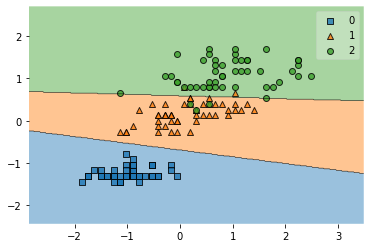

In [25]:
plot_decision_regions(X.to_numpy(),y.to_numpy().astype(int),clf=lr)

2

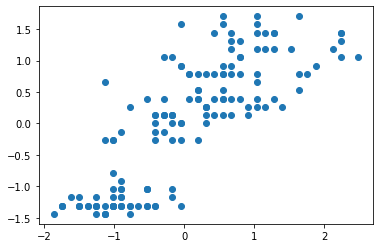

In [26]:
ys = y.to_numpy().astype(int)
x_new = X.to_numpy()
x_new_lst = x_new.tolist()
plt.scatter(x_new[:,0],x_new[:,1])
# x_new_lst
x_new.shape[1]

In [27]:
label = []
for i in ys:
    if i not in label:
        label.append(i)
        
label

[0, 1, 2]

In [28]:
# def decision_bounds(x_new,ys,label):
    
#     x_db_lst = []
#     y_db_lst = []
    
#     x_new_lst = x_new.tolist()
    
#     rescaled_xs = rescale(x_new)
#     beta = least_squares_fit(rescaled_xs, ys, 0.001, 1000, 1)
#     predictions = [predict(x_i, beta) for x_i in rescaled_xs]
    
#     random.seed(0)
#     x_train, x_test, y_train, y_test = train_test_split(rescaled_xs, ys, 0.33)

#     print(y_train)

#     learning_rate = 0.01

#     # pick a random starting point
#     beta = [random.random() for _ in range(3)]
#     beta
    
#     xs_1 = []
#     # ys = df['class'].to_numpy().tolist()
#     # ys = []
#     for i in range(len(label)-1):
#     #     xs_0 = [[1] +row[:2] for row in data_org_lst if row[2] >= 0+i  and row[2] < len(cls) - 1+i]
#         xs_0 = [[1]+x_new_lst[n] for n in range(len(x_new_lst)) if ys[n] >= 0+i and ys[n] < 2+i]
#     #     ys_0 = [row[2] for row in data_org_lst if row[2] > 0+i and row[2] < 2+i]
#         xs_1.append(xs_0)
#     #     ys.append(ys_0)
    
#     beta_unscaled = []
#     for k in range(len(label)-1):
#         means, stdevs = scale(xs_1[k])
#         beta_1= [(beta[0] - beta[1] * means[1] / stdevs[1] - beta[2] * means[2] / stdevs[2]),
#                      beta[1] / stdevs[1],
#                      beta[2] / stdevs[2]]
#         beta_unscaled.append(beta_1)
        
#     min_val = -2
#     max_val = 2.5

#     # x_db = [xi for xi in range(min_val,max_val)]
#     for k in range(len(label)-1):
#         x_db = np.linspace(min_val,max_val,len(ys))
#         x_db_lst.append(x_db)
#         y_db = [(-beta_unscaled[k][1]/beta_unscaled[k][2]*xi - beta_unscaled[k][0]/beta_unscaled[k][2])
#                 for xi in x_db]
#         y_db_lst.append(y_db)
    
#     return x_db_lst,y_db_lst
        




In [29]:
# x_db_lst2,y_db_lst2 = decision_bounds(x_new,ys,label)

In [30]:
# x_db_lst2

In [31]:
# xs_1 = []
# # ys = df['class'].to_numpy().tolist()
# # ys = []
# for i in range(len(label)-1):
# #     xs_0 = [[1] +row[:2] for row in data_org_lst if row[2] >= 0+i  and row[2] < len(cls) - 1+i]
#     xs_0 = [[1]+x_new_lst[n] for n in range(len(x_new_lst)) if ys[n] >= 0+i and ys[n] < 2+i]
# #     ys_0 = [row[2] for row in data_org_lst if row[2] > 0+i and row[2] < 2+i]
#     xs_1.append(xs_0)
# #     ys.append(ys_0)



In [32]:
# rescaled_xs = rescale(xs_1[1])
# beta = least_squares_fit(rescaled_xs, ys, 0.001, 1000, 1)
# predictions = [predict(x_i, beta) for x_i in rescaled_xs]

In [33]:
# rescaled_xs = rescale(xs_1[1])
# beta = least_squares_fit(rescaled_xs, ys, 0.001, 1000, 1)
# predictions = [predict(x_i, beta) for x_i in rescaled_xs]

In [34]:
# random.seed(0)
# x_train, x_test, y_train, y_test = train_test_split(rescaled_xs, ys, 0.33)

# print(y_train)

# learning_rate = 0.01

# # pick a random starting point
# beta = [random.random() for _ in range(3)]
# beta
# # with tqdm.trange(5000) as t:
# #     for epoch in t:
# #         gradient = negative_log_gradient(x_train, y_train, beta)
# #         beta = gradient_step(beta, gradient, -learning_rate)
# #         loss = negative_log_likelihood(x_train, y_train, beta)
# #         t.set_description(f"loss: {loss:.3f} beta: {beta}")

# # print(t)

In [35]:
# xs_0 = [[1]+x_new_lst[n] for n in range(len(x_new_lst)) if ys[n] >= 0 and ys[n] < 2]
# xs_1 = [[1]+x_new_lst[n] for n in range(len(x_new_lst)) if ys[n] >= 1 and ys[n] < 3]


In [36]:
# xs_1 = []
# # ys = df['class'].to_numpy().tolist()
# # ys = []
# for i in range(len(label)-1):
# #     xs_0 = [[1] +row[:2] for row in data_org_lst if row[2] >= 0+i  and row[2] < len(cls) - 1+i]
#     xs_0 = [[1]+x_new_lst[n] for n in range(len(x_new_lst)) if ys[n] >= 0+i and ys[n] < 2+i]
# #     ys_0 = [row[2] for row in data_org_lst if row[2] > 0+i and row[2] < 2+i]
#     xs_1.append(xs_0)
# #     ys.append(ys_0)



In [37]:
# Break up by labels
# for j in range(len(xs_0)):
# Label 1
x_0 = [x_new_lst[m] for m in range(len(x_new_lst)) if ys[m] == 0]
x_0 = np.array(x_0)
# Label 2
x_1 = [x_new_lst[m] for m in range(len(x_new_lst)) if ys[m] == 1]
x_1 = np.array(x_1)
# Label 3
x_2 = [x_new_lst[m] for m in range(len(x_new_lst)) if ys[m] == 2]
x_2 = np.array(x_2)



In [38]:
# # plt.scatter(x_new[:,0],x_new[:,1], marker = '*', color = 'red')
# plt.scatter(x_0[:,0],x_0[:,1], marker = '*', color = 'red')
# plt.scatter(x_1[:,0],x_1[:,1], marker = '+', color = 'green')
# plt.scatter(x_2[:,0],x_2[:,1], marker = 'o', color = 'blue')
# # plt.plot(x_db,y_db)
# # plt.plot(x_db_1,y_db_1)
# # plt.plot(x_db_lst2[0],y_db_lst2[0])
# # plt.plot(x_db_lst2[1],y_db_lst2[1])
# plt.grid()

In [39]:
def decision_bounds(x_new,ys,label):
    
    x_db_lst = []
    y_db_lst = []
    
    x_new_lst = x_new.tolist()
    
    xs_1 = []
    # ys = df['class'].to_numpy().tolist()
    # ys = []
    for i in range(len(label)-1):
    #     xs_0 = [[1] +row[:2] for row in data_org_lst if row[2] >= 0+i  and row[2] < len(cls) - 1+i]
        xs_0 = [[1]+x_new_lst[n] for n in range(len(x_new_lst)) if ys[n] >= 0+i and ys[n] < 2+i]
    #     ys_0 = [row[2] for row in data_org_lst if row[2] > 0+i and row[2] < 2+i]
        xs_1.append(xs_0)
    #     ys.append(ys_0)
   
   
    rescaled_xs = rescale(xs_1[1])
    beta = least_squares_fit(rescaled_xs, ys, 0.001, 1000, 1)
    predictions = [predict(x_i, beta) for x_i in rescaled_xs]
    
    random.seed(0)
    x_train, x_test, y_train, y_test = train_test_split(rescaled_xs, ys, 0.33)

#     print(y_train)

    learning_rate = 0.01

    # pick a random starting point
    beta = [random.random() for _ in range(3)]
    beta
    
#     xs_1 = []
#     # ys = df['class'].to_numpy().tolist()
#     # ys = []
#     for i in range(len(label)-1):
#     #     xs_0 = [[1] +row[:2] for row in data_org_lst if row[2] >= 0+i  and row[2] < len(cls) - 1+i]
#         xs_0 = [[1]+x_new_lst[n] for n in range(len(x_new_lst)) if ys[n] >= 0+i and ys[n] < 2+i]
#     #     ys_0 = [row[2] for row in data_org_lst if row[2] > 0+i and row[2] < 2+i]
#         xs_1.append(xs_0)
#     #     ys.append(ys_0)

    random.seed(0)
    x_train, x_test, y_train, y_test = train_test_split(rescaled_xs, ys, 0.33)
    x_train

    learning_rate = 0.01

    # pick a random starting point
    beta = [random.random() for _ in range(3)]
    y_train

    with tqdm.trange(2500) as t:
        for epoch in t:
            gradient = negative_log_gradient(x_train, y_train, beta)
            beta = gradient_step(beta, gradient, -learning_rate)
            loss = negative_log_likelihood(x_train, y_train, beta)
            t.set_description(f"loss: {loss:.3f} beta: {beta}")

    print(t)

    beta_unscaled = []
    for k in range(len(label)-1):
        means, stdevs = scale(xs_1[k])
        beta_1= [(beta[0] - beta[1] * means[1] / stdevs[1] - beta[2] * means[2] / stdevs[2]),
                     beta[1] / stdevs[1],
                     beta[2] / stdevs[2]]
        beta_unscaled.append(beta_1)
        
    min_val = -2
    max_val = 2.5

    # x_db = [xi for xi in range(min_val,max_val)]
    for k in range(len(label)-1):
        x_db = np.linspace(min_val,max_val,len(ys))
        x_db_lst.append(x_db)
        y_db = [(-beta_unscaled[k][1]/beta_unscaled[k][2]*xi - beta_unscaled[k][0]/beta_unscaled[k][2])
                for xi in x_db]
        y_db_lst.append(y_db)
    
    return x_db_lst,y_db_lst
        




In [40]:
x_db_lst3,y_db_lst3 = decision_bounds(x_new,ys,label)

C:\Users\USER\AppData\Local\Temp/ipykernel_37972/2746858823.py:39: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return sum(v_i * w_i for v_i, w_i in zip(v, w))
  0%|                                                                                                                                             | 0/2500 [00:00<?, ?it/s]C:\Users\USER\AppData\Local\Temp/ipykernel_37972/2746858823.py:15: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return [sum(vector[i] for vector in vectors)
C:\Users\USER\AppData\Local\Temp/ipykernel_37972/2746858823.py:164: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin in

loss: 4.276 beta: [ 0.31263739  0.2225783  10.58747186]: 100%|████████████████████████████████████████████████████████████████████████| 2500/2500 [00:11<00:00, 211.07it/s]


In [41]:
# rescaled_xs = rescale(xs_1[1])
# beta = least_squares_fit(rescaled_xs, ys, 0.001, 1000, 1)
# predictions = [predict(x_i, beta) for x_i in rescaled_xs]

In [42]:
# random.seed(0)
# x_train, x_test, y_train, y_test = train_test_split(rescaled_xs, ys, 0.33)
# x_train

# learning_rate = 0.01

# # pick a random starting point
# beta = [random.random() for _ in range(3)]
# y_train

# with tqdm.trange(2500) as t:
#     for epoch in t:
#         gradient = negative_log_gradient(x_train, y_train, beta)
#         beta = gradient_step(beta, gradient, -learning_rate)
#         loss = negative_log_likelihood(x_train, y_train, beta)
#         t.set_description(f"loss: {loss:.3f} beta: {beta}")

# print(t)

In [43]:
# means, stdevs = scale(xs_1[0])
# beta_unscaled_2 = [(beta[0] - beta[1] * means[1] / stdevs[1] - beta[2] * means[2] / stdevs[2]),
#                  beta[1] / stdevs[1],
#                  beta[2] / stdevs[2]]
# beta_unscaled_2

In [44]:
# means, stdevs = scale(xs_1[1])
# beta_unscaled_1= [(beta[0] - beta[1] * means[1] / stdevs[1] - beta[2] * means[2] / stdevs[2]),
#                  beta[1] / stdevs[1],
#                  beta[2] / stdevs[2]]
# beta_unscaled_1

In [45]:
# beta1 = []
# for k in range(len(label)-1):
#     means, stdevs = scale(xs_1[k])
#     beta_unscaled_1= [(beta[0] - beta[1] * means[1] / stdevs[1] - beta[2] * means[2] / stdevs[2]),
#                  beta[1] / stdevs[1],
#                  beta[2] / stdevs[2]]
#     beta1.append(beta_unscaled_1)
# beta1[0]

In [46]:
# # min_range = (data_marks.min())
# # min_range = math.floor(min_range[0])
# # max_range = (data_marks.max())
# # max_range = math.ceil(max_range[0])

# # min_val = math.floor(np.min(exp_val))
# # max_val = math.ceil(np.max(exp_val))

# min_val = -2
# max_val = 2.5

# # min_val = math.floor(np.min(x_new_lst))
# # max_val = math.ceil(np.max(x_new_lst))

# # x_db = [xi for xi in range(min_val,max_val)]
# x_db = np.linspace(min_val,max_val,len(ys))
# # y_db = [(-beta_unscaled[1]/beta_unscaled[2]*xi - beta_unscaled[0]/beta_unscaled[2])
# #         for xi in x_db]

# # y_db = [(-beta1[0][1]/beta1[0][2]*xi - beta1[0][0]/beta1[0][2])
# #         for xi in x_db]

# y_db = [(-beta_unscaled_2[1]/beta_unscaled_2[2]*xi - beta_unscaled_2[0]/beta_unscaled_2[2])
#         for xi in x_db]
# # 
# print(min_val)
# print(max_val)

# xx = []
# yy = []
# for k in range(len(y_db)):
#     xx.append(x_new_lst[k][0])
#     yy.append(x_new_lst[k][1])
# # x_new_lst
# max(xx)


In [47]:
# min_val = -2
# max_val = 2.5

# # min_val = math.floor(np.min(x_new_lst))
# # max_val = math.ceil(np.max(x_new_lst))

# # x_db = [xi for xi in range(min_val,max_val)]
# x_db_1 = np.linspace(min_val,max_val,len(ys))
# y_db_1 = [(-beta_unscaled_1[1]/beta_unscaled_1[2]*xi - beta_unscaled_1[0]/beta_unscaled_1[2])
#         for xi in x_db_1]
# print(min_val)
# print(max_val)


In [48]:
# rescaled_xs = rescale(x_new)
# beta = least_squares_fit(rescaled_xs, ys, 0.001, 1000, 1)
# predictions = [predict(x_i, beta) for x_i in rescaled_xs]

In [49]:
# x_db_lst,y_db_lst = decision_boundary_2(x_new_lst,ys,label)

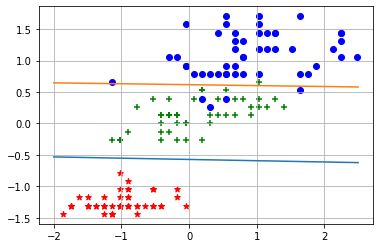

In [50]:
# plt.scatter(x_new[:,0],x_new[:,1], marker = '*', color = 'red')
plt.scatter(x_0[:,0],x_0[:,1], marker = '*', color = 'red')
plt.scatter(x_1[:,0],x_1[:,1], marker = '+', color = 'green')
plt.scatter(x_2[:,0],x_2[:,1], marker = 'o', color = 'blue')
# plt.plot(x_db_1,y_db_1)
# plt.plot(x_db,y_db)
plt.plot(x_db_lst3[0],y_db_lst3[0])
plt.plot(x_db_lst3[1],y_db_lst3[1])
plt.grid()